In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/test'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/validation'

categories = os.listdir(train_dir)

### Fetch Training Data

In [ ]:
name = []
label = []
for i in range(len(categories)):
  
  filenames=os.listdir(train_dir+"/"+categories[i])
  for f_name in filenames:
    name.append(f_name)
    label.append(categories[i])

df_train = pd.DataFrame({"Path":name , "Category":label})
df_train

,Path,Category
0,Training_89462736.jpg,angry
1,Training_75201127.jpg,angry
2,Training_92321166.jpg,angry
3,Training_63914663.jpg,angry
4,Training_38970819.jpg,angry
...,...,...
28714,Training_62165241.jpg,neutral
28715,Training_30971124.jpg,neutral
28716,Training_28069544.jpg,neutral
28717,Training_48150900.jpg,neutral


In [ ]:
df_train.shape
total_train=df_train.shape[0]        # Size of Train (Needed for model.fit_generator)

## Fetch Validation Data


In [ ]:
name = []
label = []
for i in range(len(categories)):
  
  filenames=os.listdir(val_dir+"/"+categories[i])
  for f_name in filenames:
    name.append(f_name)
    label.append(categories[i])

df_val = pd.DataFrame({"Path":name , "Category":label})
df_val

,Path,Category
0,PublicTest_26532100.jpg,angry
1,PublicTest_48156348.jpg,angry
2,PublicTest_18770630.jpg,angry
3,PublicTest_47374366.jpg,angry
4,PrivateTest_76880087.jpg,angry
...,...,...
5423,PublicTest_24691289.jpg,neutral
5424,PublicTest_63640849.jpg,neutral
5425,PublicTest_85787847.jpg,neutral
5426,PublicTest_64856942.jpg,neutral


In [ ]:
df_val.shape

(5428, 2)

### Fetch Test Data

In [ ]:
name = []
label = []
for i in range(len(categories)):
  
  filenames=os.listdir(test_dir+"/"+categories[i])
  for f_name in filenames:
    name.append(f_name)
    label.append(categories[i])

df_test = pd.DataFrame({"Path":name , "Category":label})
df_test

,Path,Category
0,PrivateTest_19777137.jpg,angry
1,PrivateTest_4115089.jpg,angry
2,PrivateTest_50685265.jpg,angry
3,PrivateTest_26910183.jpg,angry
4,PrivateTest_47881235.jpg,angry
...,...,...
1745,PrivateTest_66773819.jpg,neutral
1746,PrivateTest_67534145.jpg,neutral
1747,PrivateTest_68065868.jpg,neutral
1748,PrivateTest_66109599.jpg,neutral


In [ ]:
df_test.shape

(1750, 2)

In [ ]:
df_test["Category"].value_counts()

fear        300
neutral     300
angry       300
happy       300
sad         300
surprise    200
disgust      50
Name: Category, dtype: int64

## Distribution of Train Data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


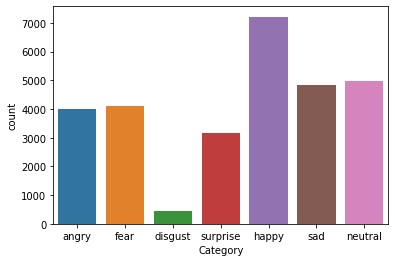

In [ ]:
sns.countplot(df_train["Category"])

### Visualize Our Data

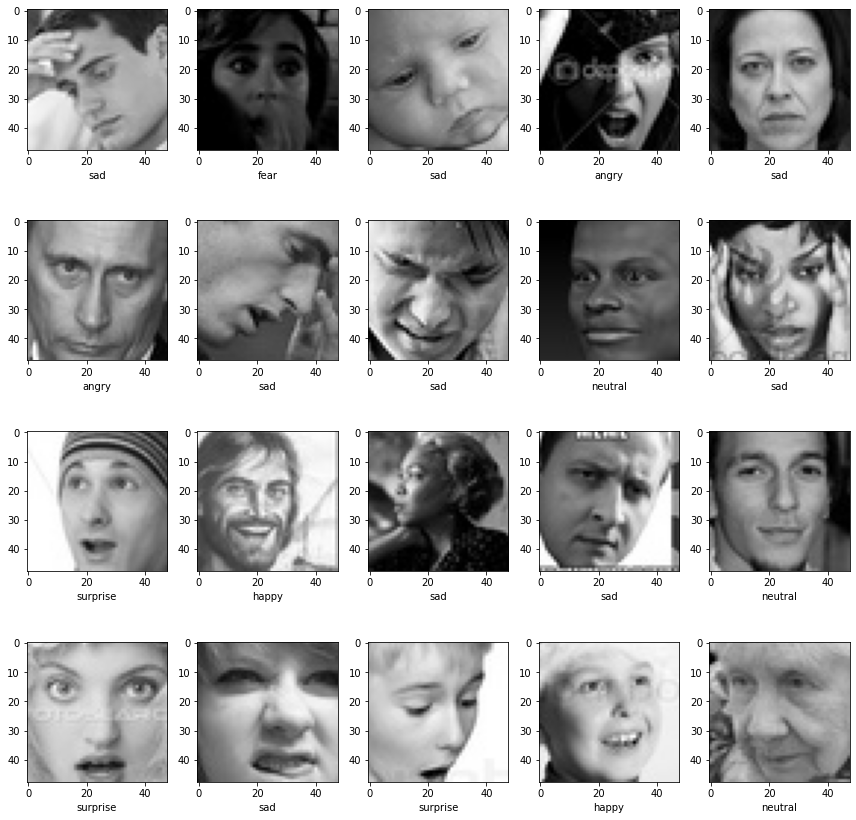

In [ ]:
Image_Width=48
Image_Height=48
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

plt.figure(figsize=(12, 12))
j=0

for i in np.random.randint(0,28719 , 20):
  img = load_img(train_dir+"/"+df_train["Category"].iloc[i] +"/"+df_train["Path"].iloc[i], target_size=Image_Size)
  plt.subplot(4, 5, j+1)
  j=j+1
  plt.imshow(img)
  plt.xlabel(df_train["Category"].iloc[i]) # Print Predicted category
plt.tight_layout()
plt.show()


## Create Generators for Train , Validation , Test

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255 )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        
        target_size=(128,128),
        batch_size=64,
        color_mode="rgb", ## V.V.V IMP as our original data is grayscale, it wont be accepted by VGG unless converted to RGB
        class_mode="categorical")

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(128,128),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128,128),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')

Found 28719 images belonging to 7 classes.
Found 5428 images belonging to 7 classes.
Found 1750 images belonging to 7 classes.


### Build CNN Network

In [ ]:
# Defining VGG19 as a Deep Convolutional Neural Network
from keras.applications import VGG19 #For Transfer Learning
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (128,128,3), classes = 7)
base_model.trainable = False # Setting trainable to false because we want to make sure that this layer isn’t re-trained.

#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

#Adding the Dense layers along with activation and batch normalization

#model.add(Dense(1024,activation=('relu'))) #,input_dim=512
#model.add(Dropout(0.25))
model.add(Dense(512,activation=('relu'))) 
model.add(Dropout(0.25))
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(0.25))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(0.25))

model.add(Dense(7,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [ ]:
# To see Architecture of VGG19
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
#Learning Rate Annealer
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='accuracy', factor=.01, patience=3, min_lr=1e-5)

In [ ]:
#Initializing the hyperparameters

from keras.optimizers import SGD,Adam

batch_size= 100
epochs=30
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
a = model.fit_generator(train_generator,epochs = epochs, steps_per_epoch = total_train//batch_size, validation_data = validation_generator, callbacks=[lrr], verbose = 1)


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


287/287 [==============================] - 45s 140ms/step - loss: 1.8611 - accuracy: 0.2334 - val_loss: 1.6836 - val_accuracy: 0.3148
Epoch 2/30
287/287 [==============================] - 37s 128ms/step - loss: 1.7331 - accuracy: 0.3004 - val_loss: 1.6552 - val_accuracy: 0.3712
Epoch 3/30
287/287 [==============================] - 41s 144ms/step - loss: 1.6593 - accuracy: 0.3446 - val_loss: 1.5310 - val_accuracy: 0.4200
Epoch 4/30
287/287 [==============================] - 38s 132ms/step - loss: 1.6229 - accuracy: 0.3656 - val_loss: 1.5016 - val_accuracy: 0.4329
Epoch 5/30
287/287 [==============================] - 38s 132ms/step - loss: 1.5739 - accuracy: 0.3785 - val_loss: 1.5461 - val_accuracy: 0.4035
Epoch 6/30
287/287 [==============================] - 38s 133ms/step - loss: 1.5669 - accuracy: 0.3864 - val_loss: 1.4731 - val_accuracy: 0.4398
Epoch 7/30
287/287 [==============================] - 39s 134ms/step - loss: 1.5473 - accuracy: 0.3921 - val_loss: 1.4495 - val_accuracy: 0.4

In [ ]:
#model.fit_generator(train_generator, steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=10, validation_data=validation_generator, validation_steps=validation_generator.samples/validation_generator.batch_size)

np.round(train_generator.samples/train_generator.batch_size)


449.0

In [ ]:
# To Use this model, need image of 128*128 shape

# Save
model.save( filepath="/content/drive/MyDrive/Colab Notebooks/Projects DL/MoodRecognition/model_1_VGG19_trainTrue_30epoch_XAccuracy.h5")

# To Load the Model
#from keras.models import load_model
#model = load_model("/content/drive/MyDrive/Colab Notebooks/Projects DL/dogcat/model3_catsVSdogs_15epoch_92Accuracy.h5")

In [ ]:
# 15 Epochs
model.evaluate(validation_generator)

In [ ]:
# 15 Epochs
model.evaluate(test_generator)

In [ ]:
# 15 Epochs
model.evaluate(train_generator)

In [ ]:
# TRY 1 Without Dropout
## validation_generator : loss: 1.9862 - accuracy: 0.6796
## test_generator : loss: 2.1074 - accuracy: 0.6537
## train_generator : loss: 0.0479 - accuracy: 0.9851

# TRY 2 With Dropout

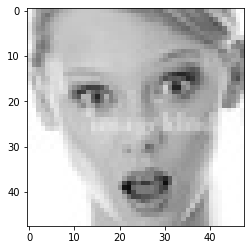

In [ ]:
img = load_img(train_dir+"/"+df_train["Category"].iloc[i] +"/"+df_train["Path"].iloc[i], target_size=Image_Size)

plt.imshow(img)